In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Math, display
from scipy.stats import t

In [2]:
from IPython.display import display, Math, Markdown

display(Markdown("### Standard f2"))
display(Math(r'f_2 = 50 \times \log_{10}\left(\frac{100}{\sqrt{1 + \frac{1}{n}\sum_{t=1}^{n}(R_t - T_t)^2}}\right)'))

display(Markdown("### Bias-Corrected f2 (Shah et al., 1998)"))
display(Math(r'bc\text{-}f_2 = 50 \times \log_{10}\left(\frac{100}{\sqrt{1 + \frac{1}{n}\sum_{t=1}^{n}\left[(R_t - T_t)^2 - \frac{s_{R_t}^2 + s_{T_t}^2}{2}\right]}}\right)'))

display(Markdown("### Expected f2 (Shah et al., 1998)"))
display(Math(r'f_{2,exp} = 50 \times \log_{10}\left(\frac{100}{\sqrt{1 + \frac{1}{P}\left[\sum_{t=1}^{P}(\bar{R}_t - \bar{T}_t)^2 + \frac{1}{n}\sum_{t=1}^{P}(S_{R,t}^2 + S_{T,t}^2)\right]}}\right)'))

display(Markdown("### Where:"))
display(Math(r'R_t = \text{mean \% dissolved of reference at time } t'))
display(Math(r'T_t = \text{mean \% dissolved of test at time } t'))
display(Math(r's_{R_t}^2 = \text{sample variance of reference at time } t'))
display(Math(r's_{T_t}^2 = \text{sample variance of test at time } t'))
display(Math(r'n = \text{number of time points}'))

### Standard f2

<IPython.core.display.Math object>

### Bias-Corrected f2 (Shah et al., 1998)

<IPython.core.display.Math object>

### Expected f2 (Shah et al., 1998)

<IPython.core.display.Math object>

### Where:

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [3]:
# 1. Define folder and get list of CSVs
data_folder = 'data'
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]

# 2. Display the list with numbers
if not files:
    print(f"❌ No CSV files found in '{data_folder}' folder. Please upload one first!")
elif len(files) < 2:
    print(f"⚠️ Only {len(files)} CSV file found. You need at least 2 files (reference and test).")
else:
    print("--- Available Data Files ---")
    for i, filename in enumerate(files):
        print(f"[{i}] {filename}")

--- Available Data Files ---
[0] Test.csv
[1] Reference.csv


In [4]:
# 3. Ask for reference and test file indices
ref_choice = input("\nEnter the number for the REFERENCE file: ")
test_choice = input("Enter the number for the TEST file: ")
    
try:
    ref_index = int(ref_choice)
    test_index = int(test_choice)
    
    if ref_index == test_index:
        print("❌ Reference and test files must be different!")
    else:
        ref_file = files[ref_index]
        test_file = files[test_index]
        ref_path = os.path.join(data_folder, ref_file)
        test_path = os.path.join(data_folder, test_file)
        
        print(f"✅ Reference: {ref_file}")
        print(f"✅ Test: {test_file}")
except (ValueError, IndexError):
    print("❌ Invalid selection. Please run the cell again and enter valid numbers.")

✅ Reference: Reference.csv
✅ Test: Test.csv


In [5]:
# Load both files and check structure
if 'ref_path' in locals() and 'test_path' in locals():
    ref_data = pd.read_csv(ref_path, sep=';', index_col=0)
    test_data = pd.read_csv(test_path, sep=';', index_col=0)
    
    print(f"\n--- Reference File: {ref_file} ---")
    print(f"Shape: {ref_data.shape}")
    print(f"Time points: {ref_data.index.tolist()}")
    print(f"Number of tablets: {ref_data.shape[1]}")
    
    print(f"\n--- Test File: {test_file} ---")
    print(f"Shape: {test_data.shape}")
    print(f"Time points: {test_data.index.tolist()}")
    print(f"Number of tablets: {test_data.shape[1]}")
    
    # Check if TIME POINTS match (index)
    if not ref_data.index.equals(test_data.index):
        print("\n❌ ERROR: Time points don't match between files!")
        print(f"Reference time points: {ref_data.index.tolist()}")
        print(f"Test time points: {test_data.index.tolist()}")
        print("f2 calculations require identical time points.")
    else:
        print("\n✅ Time points match!")
    
    # Check if NUMBER of tablets is the same
    if ref_data.shape[1] != test_data.shape[1]:
        print(f"\n⚠️ WARNING: Different number of tablets")
        print(f"Reference: {ref_data.shape[1]} tablets")
        print(f"Test: {test_data.shape[1]} tablets")
        print("This is acceptable but may affect variability assessment.")
    else:
        print(f"✅ Both datasets have {ref_data.shape[1]} tablets")
        
else:
    print("❌ Files not selected. Run the previous cell first.")


--- Reference File: Reference.csv ---
Shape: (6, 12)
Time points: [10, 15, 20, 30, 45, 60]
Number of tablets: 12

--- Test File: Test.csv ---
Shape: (6, 12)
Time points: [10, 15, 20, 30, 45, 60]
Number of tablets: 12

✅ Time points match!
✅ Both datasets have 12 tablets


In [6]:
# === CELL: Load and preserve original data ===
if 'ref_path' in locals() and 'test_path' in locals():
    ref_data = pd.read_csv(ref_path, sep=';', index_col=0)
    test_data = pd.read_csv(test_path, sep=';', index_col=0)
    
    # Preserve originals
    ref_data_original = ref_data.copy()
    test_data_original = test_data.copy()
    
    print("✅ Data loaded and original copies preserved")

# === CELL: Calculate statistics (can run multiple times safely) ===
# Always calculate from originals
ref_means = ref_data_original.mean(axis=1)
ref_sds = ref_data_original.std(axis=1)
ref_rsds = ((ref_sds / ref_means) * 100)

test_means = test_data_original.mean(axis=1)
test_sds = test_data_original.std(axis=1)
test_rsds = ((test_sds / test_means) * 100)

# Update working DataFrame
ref_data = ref_data_original.copy()  # Fresh copy
ref_data['Mean'] = ref_means
ref_data['SD'] = ref_sds
ref_data['RSD%'] = ref_rsds

test_data = test_data_original.copy()  # Fresh copy
test_data['Mean'] = test_means
test_data['SD'] = test_sds
test_data['RSD%'] = test_rsds


✅ Data loaded and original copies preserved


In [ ]:
'''# Checking index values
row_count = len(ref_data.index)
ref_data_early = ref_data[ref_data.index <=15]
test_data_early = test_data[test_data.index <=15]

for row in range(row_count):
    if ref_data.index[row] <= 15 AND ref_data['RSD%']>20
    

    

'''

In [7]:
# For reference data
# Create the threshold column first
ref_data['RSD_Threshold'] = ref_data.index.map(lambda x: 20 if x <= 15 else 10)

# Check if RSD exceeds threshold
ref_data['RSD_Status'] = ref_data.apply(
    lambda row: 'Fail' if row['RSD%'] > row['RSD_Threshold'] else 'Pass',
    axis=1
)

# Repeat for test data
test_data['RSD_Threshold'] = test_data.index.map(lambda x: 20 if x <= 15 else 10)
test_data['RSD_Status'] = test_data.apply(
    lambda row: 'Fail' if row['RSD%'] > row['RSD_Threshold'] else 'Pass',
    axis=1
)

In [8]:
ref_data.style.format({
    'Mean': '{:.2f}',
    'SD': '{:.2f}',
    'RSD%': '{:.2f}'
})

,1,2,3,4,5,6,7,8,9,10,11,12,Mean,SD,RSD%,RSD_Threshold,RSD_Status
min/tbl.,,,,,,,,,,,,,,,,,
10,40.600000,47.020000,46.090000,41.830000,47.170000,44.660000,41.520000,45.090000,47.250000,43.470000,47.290000,45.630000,44.80,2.42,5.39,20,Pass
15,52.080000,57.480000,55.100000,51.150000,54.170000,53.680000,52.290000,53.260000,55.190000,50.410000,54.990000,53.610000,53.62,1.96,3.66,20,Pass
20,58.150000,64.840000,62.460000,58.350000,59.380000,59.920000,59.310000,58.700000,60.970000,54.960000,60.430000,60.340000,59.82,2.42,4.05,10,Pass
30,65.670000,73.190000,72.850000,66.060000,65.410000,66.760000,68.380000,65.810000,68.760000,60.900000,68.090000,68.010000,67.49,3.31,4.91,10,Pass
45,74.080000,80.550000,80.140000,71.890000,71.130000,73.330000,76.760000,72.120000,75.290000,65.990000,75.460000,74.750000,74.29,3.96,5.33,10,Pass
60,78.550000,85.540000,84.150000,75.760000,74.880000,77.650000,81.400000,75.350000,79.970000,68.960000,79.370000,78.940000,78.38,4.42,5.64,10,Pass


In [9]:
test_data.style.format({
    'Mean': '{:.2f}',
    'SD': '{:.2f}',
    'RSD%': '{:.2f}'
})

,1,2,3,4,5,6,7,8,9,10,11,12,Mean,SD,RSD%,RSD_Threshold,RSD_Status
min/tbl.,,,,,,,,,,,,,,,,,
10,48.610000,54.020000,52.460000,49.920000,49.490000,66.160000,44.170000,55.100000,44.100000,53.480000,47.730000,50.080000,51.28,5.86,11.43,20,Pass
15,61.550000,65.760000,63.050000,57.200000,57.910000,74.980000,52.150000,68.250000,55.650000,63.170000,56.740000,58.900000,61.28,6.27,10.23,20,Pass
20,69.550000,72.990000,69.900000,61.310000,64.470000,80.300000,57.220000,75.950000,63.540000,68.380000,62.530000,63.980000,67.51,6.62,9.81,10,Pass
30,78.460000,80.810000,78.750000,67.290000,73.880000,86.990000,62.730000,84.730000,72.170000,77.220000,70.820000,70.820000,75.39,7.11,9.43,10,Pass
45,85.530000,87.070000,85.110000,72.320000,80.300000,91.570000,66.410000,91.590000,77.260000,83.940000,76.840000,77.430000,81.28,7.62,9.37,10,Pass
60,89.070000,90.450000,88.470000,75.510000,83.870000,93.750000,68.930000,69.770000,80.750000,87.800000,81.050000,80.890000,82.53,7.98,9.68,10,Pass


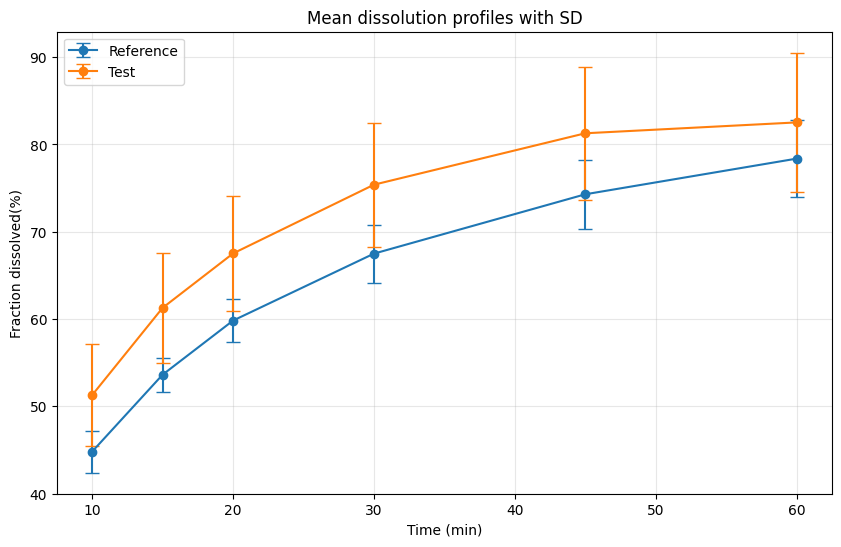

In [10]:
# Create figure
plt.figure(figsize=(10, 6))

# Plot reference with error bars
plt.errorbar(ref_data.index, ref_data['Mean'], yerr=ref_data['SD'], label='Reference', marker='o', capsize=5)

# Plot test with error bars
plt.errorbar(test_data.index, test_data['Mean'], yerr=test_data['SD'], label='Test', marker='o', capsize=5)

# Labels and formatting
plt.xlabel('Time (min)')
plt.ylabel('Fraction dissolved(%)')
plt.title('Mean dissolution profiles with SD')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [11]:
#Calculation of the f1 difference factor
abs_diff = abs(ref_data['Mean'] - test_data['Mean'])
sum_abs_diff = sum(abs_diff)  # or abs_diff.sum()
sum_Rt = sum(ref_data['Mean'])  # or ref_data['Mean'].sum()
f1 = 100 * sum_abs_diff / sum_Rt

print("Diffrence factor f1")
print(f"f1 = {f1:.2f}")
Math(r'f_1 = \frac{\sum_{t=1}^{n} |R_t - T_t|}{\sum_{t=1}^{n} R_t} \times 100')

Diffrence factor f1
f1 = 10.80


<IPython.core.display.Math object>

In [12]:
# Calculation of the similarity factor f2
squared_diff = (ref_data['Mean'] - test_data['Mean'])**2
sum_squared_diff = sum(squared_diff)
n = len(ref_data['Mean'])

# Calculate f2
f2 = 50 * np.log10(100 / np.sqrt(1 + (1/n) * sum_squared_diff))

print("Similarity factor f2")
print(f"f2 = {f2:.2f}")
Math(r'f_2 = 50 \times \log_{10}\left(\frac{100}{\sqrt{1 + \frac{1}{n}\sum_{t=1}^{n}(R_t - T_t)^2}}\right)')

Similarity factor f2
f2 = 57.74


<IPython.core.display.Math object>

In [16]:
n_iter = 5000
f2_bs = np.zeros(n_iter)

for i in range(n_iter):
    # Get number of tablets (columns)
    n_tablets = ref_data_original.shape[1]
    
    # Generate random column indices with replacement - INDEPENDENTLY
    ref_indices = np.random.choice(n_tablets, size=n_tablets, replace=True)
    test_indices = np.random.choice(n_tablets, size=n_tablets, replace=True)
    
    # Resample columns (tablets)
    ref_resample = ref_data_original.iloc[:, ref_indices]
    test_resample = test_data_original.iloc[:, test_indices]
    
    # Calculate means across tablets (axis=1 - across columns)
    ref_resample_mean = ref_resample.mean(axis=1)
    test_resample_mean = test_resample.mean(axis=1)
    
    # Calculate f2
    squared_diff = (ref_resample_mean - test_resample_mean)**2
    sum_squared_diff = sum(squared_diff)
    n_timepoints = len(ref_resample_mean)
    
    f2_bs[i] = 50 * np.log10(100 / np.sqrt(1 + (1/n_timepoints) * sum_squared_diff))

# Parametric confidence interval calculation
# Calculate the standard error
f2_bs_se = np.sqrt(np.sum((f2_bs - f2_bs.mean())**2) / (len(f2_bs) - 1))
#f2_bs_se = np.std(f2_bs, ddof=1) cleaner alternative

# Calculate the t-value for the given confidence level and degree of freedom
alpha = 0.05 # Confidence level, 0.05 for 90% two tail CI
deg_f = len(f2_bs)-1 #degrees of freedom
tval = t.ppf(1-alpha, deg_f)

# Confidence interval for the f2 value
f2_bs_ci = (f2_bs.mean() - tval * f2_bs_se, f2_bs.mean() + tval * f2_bs_se,)


# Summary statistics
print("=== Bootstrap f2 Results ===")
print(f"Number of bootstrap: {n_iter}")
print(f"Original f2: {f2:.2f}")  # Your original f2 calculation
print(f"Bootstrap mean f2: {f2_bs.mean():.2f}")
print(f"Bootstrap median f2: {np.median(f2_bs):.2f}")
print(f"\n90% Quantiles:")
print(f"  5% percentile: {np.percentile(f2_bs, 5):.2f}")
print(f"  95% percentile: {np.percentile(f2_bs, 95):.2f}")
# Check if distribution is normal
print(f"Skewness: {pd.Series(f2_bs).skew():.3f}")  # Close to 0 = symmetric
print(f"Kurtosis: {pd.Series(f2_bs).kurt():.3f}")  # Close to 0 = normal
# Parametric confidence interval
print(f"Parametric CI: ({f2_bs_ci[0]:.2f}, {f2_bs_ci[1]:.2f})")
Math(r'f_2 = 50 \times \log_{10}\left(\frac{100}{\sqrt{1 + \frac{1}{n}\sum_{t=1}^{n}(R_t - T_t)^2}}\right)')

=== Bootstrap f2 Results ===
Number of bootstrap: 5000
Original f2: 57.74
Bootstrap mean f2: 58.32
Bootstrap median f2: 57.71

90% Quantiles:
  5% percentile: 49.59
  95% percentile: 69.15
Skewness: 0.648
Kurtosis: 0.725
Parametric CI: (48.39, 68.25)


<IPython.core.display.Math object>

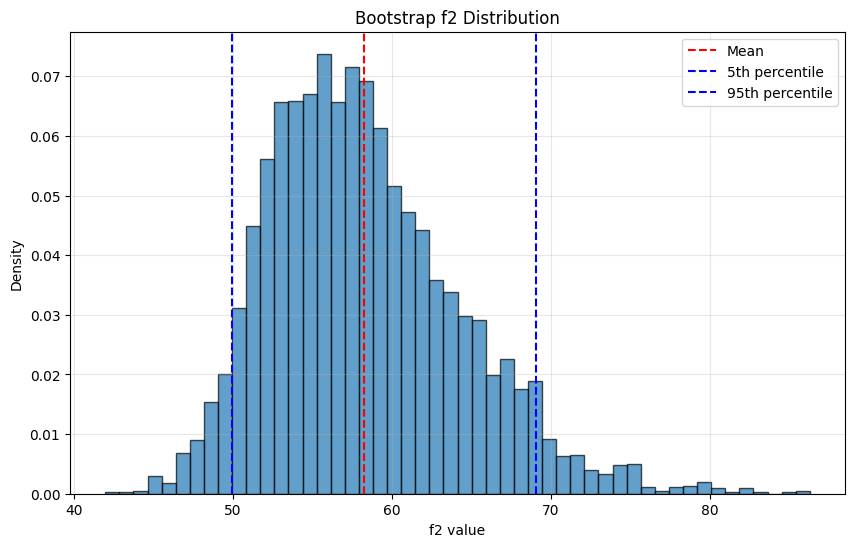

In [14]:
# Plot the bootstrap distribution
plt.figure(figsize=(10, 6))
plt.hist(f2_bs, bins=50, density=True, alpha=0.7, edgecolor='black')
plt.axvline(f2_bs.mean(), color='red', linestyle='--', label='Mean')
plt.axvline(np.percentile(f2_bs, 5), color='blue', linestyle='--', label='5th percentile')
plt.axvline(np.percentile(f2_bs, 95), color='blue', linestyle='--', label='95th percentile')
plt.xlabel('f2 value')
plt.ylabel('Density')
plt.title('Bootstrap f2 Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [25]:
n_iter = 5000
f2_bs_exp = np.zeros(n_iter)

for i in range(n_iter):
    # Resample
    n_tablets = ref_data_original.shape[1]
    ref_indices = np.random.choice(n_tablets, size=n_tablets, replace=True)
    test_indices = np.random.choice(n_tablets, size=n_tablets, replace=True)
    
    ref_resample = ref_data_original.iloc[:, ref_indices]
    test_resample = test_data_original.iloc[:, test_indices]
    
    # Calculate means AND variances
    ref_mean = ref_resample.mean(axis=1)
    test_mean = test_resample.mean(axis=1)
    ref_var = ref_resample.var(axis=1, ddof=1)
    test_var = test_resample.var(axis=1, ddof=1)
    
    # Shah et al. Expected f2 formula
    P = len(ref_mean)  # Number of time points
    n = ref_resample.shape[1]  # Number of tablets (sample size)
    
    # First term: sum of squared differences between means
    sum_squared_diff = ((ref_mean - test_mean)**2).sum()
    
    # Second term: sum of variances (both ref and test)
    sum_variances = (ref_var + test_var).sum()
    
    # Shah formula: 1 + (1/P)×Σ(R-T)² + (1/(n×P))×Σ(S²_R + S²_T)
    inner_value = 1 + (1/P) * sum_squared_diff + (1/(n*P)) * sum_variances
    
    f2_bs_exp[i] = 50 * np.log10(100 / np.sqrt(inner_value))

# Summary statistics
print("=== Bootstrap f2 Results ===")
print(f"Number of bootstrap: {n_iter}")
print(f"Original f2: {f2:.2f}")  # Your original f2 calculation
print(f"Bootstrap mean f2: {f2_bs_exp.mean():.2f}")
print(f"Bootstrap median f2: {np.median(f2_bs_exp):.2f}")
print(f"\n90% Quantiles:")
print(f"  5% percentile: {np.percentile(f2_bs_exp, 5):.2f}")
print(f"  95% percentile: {np.percentile(f2_bs_exp, 95):.2f}")
# Check if distribution is normal
print(f"Skewness: {pd.Series(f2_bs_exp).skew():.3f}")  # Close to 0 = symmetric
print(f"Kurtosis: {pd.Series(f2_bs_exp).kurt():.3f}")  # Close to 0 = normal

# Similarity assessment
lower_ci = np.round(np.percentile(f2_bs_exp, 5))
if lower_ci >= 50:
    print(f"\n✅ SIMILAR: Lower CI ({lower_ci:.0f}) ≥ 50")
else:
    print(f"\n❌ NOT SIMILAR: Lower CI ({lower_ci:.0f}) < 50")

display(Math(r'f_{2,exp} = 50 \times \log_{10}\left(\frac{100}{\sqrt{1 + \frac{1}{P}\left[\sum_{t=1}^{P}(\bar{R}_t - \bar{T}_t)^2 + \frac{1}{n}\sum_{t=1}^{P}(S_{R,t}^2 + S_{T,t}^2)\right]}}\right)'))

=== Bootstrap f2 Results ===
Number of bootstrap: 5000
Original f2: 57.74
Bootstrap mean f2: 57.17
Bootstrap median f2: 56.63

90% Quantiles:
  5% percentile: 49.19
  95% percentile: 66.81
Skewness: 0.491
Kurtosis: 0.239

❌ NOT SIMILAR: Lower CI (49) < 50


<IPython.core.display.Math object>

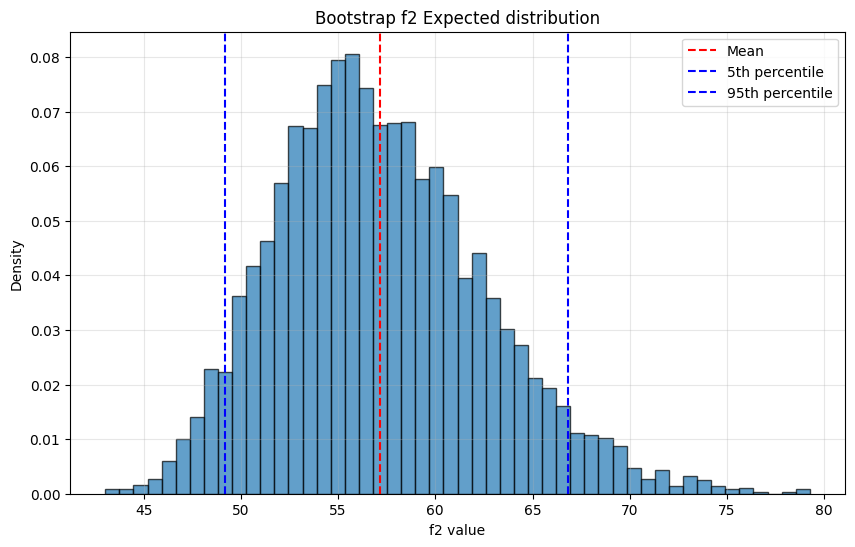

In [26]:
# Plot the bootstrap distribution
plt.figure(figsize=(10, 6))
plt.hist(f2_bs_exp, bins=50, density=True, alpha=0.7, edgecolor='black')
plt.axvline(f2_bs_exp.mean(), color='red', linestyle='--', label='Mean')
plt.axvline(np.percentile(f2_bs_exp, 5), color='blue', linestyle='--', label='5th percentile')
plt.axvline(np.percentile(f2_bs_exp, 95), color='blue', linestyle='--', label='95th percentile')
plt.xlabel('f2 value')
plt.ylabel('Density')
plt.title('Bootstrap f2 Expected distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [22]:
f2_bs_bc = np.full(n_iter, np.nan)  # NaN instead of zeros!
invalid_count = 0                       # Counter before loop

for i in range(n_iter):
    # Resample
    n_tablets = ref_data_original.shape[1]
    ref_indices = np.random.choice(n_tablets, size=n_tablets, replace=True)
    test_indices = np.random.choice(n_tablets, size=n_tablets, replace=True)
    
    ref_resample = ref_data_original.iloc[:, ref_indices]
    test_resample = test_data_original.iloc[:, test_indices]
    
    # Calculate means AND variances
    ref_mean = ref_resample.mean(axis=1)
    test_mean = test_resample.mean(axis=1)
    ref_var = ref_resample.var(axis=1, ddof=1)
    test_var = test_resample.var(axis=1, ddof=1)
    
    # Expected f2 formula (variance ADDED)
    P = len(ref_mean)  # Number of time points
    n = ref_resample.shape[1]  # Number of tablets (sample size)
    
    # First term: sum of squared differences between means
    sum_squared_diff = ((ref_mean - test_mean)**2).sum()
    
    # Second term: sum of variances (both ref and test)
    sum_variances = (ref_var + test_var).sum()

    # Shah formula: 1 + (1/P)×Σ(R-T)² + (1/(n×P))×Σ(S²_R + S²_T)
    inner_value = 1 + (1/P) * sum_squared_diff - (1/(n*P)) * sum_variances
    
    if inner_value > 0:
        f2_bs_bc[i] = 50 * np.log10(100 / np.sqrt(inner_value))
    else:
        invalid_count += 1      

# Summary statistics
print("=== E(f2) Bootstrap Results ===")

# Calculate invalid rate FIRST
f2_bc_valid = f2_bs_bc[~np.isnan(f2_bs_bc)]
invalid_rate = invalid_count / n_iter

# Tiered warning assessment
if invalid_count == 0:
    bc2_status = "✅ All iterations valid"
    bc2_reliable = True
elif invalid_rate <= 0.05:
    bc2_status = f"⚠️ Minor: {invalid_count} invalid iterations ({invalid_rate*100:.1f}%)"
    bc2_reliable = True
elif invalid_rate <= 0.10:
    bc2_status = f"⚠️ Moderate: {invalid_count} invalid iterations ({invalid_rate*100:.1f}%)"
    bc2_reliable = True
elif invalid_rate <= 0.50:
    bc2_status = f"❌ High: {invalid_count} invalid iterations ({invalid_rate*100:.1f}%)"
    bc2_reliable = False
else:
    bc2_status = f"❌ Critical: {invalid_count} invalid iterations ({invalid_rate*100:.1f}%)"
    bc2_reliable = False

# Always print status first
print(bc2_status)
print(f"Original f2: {f2:.2f}")

# Only print statistics if reliable
if bc2_reliable and len(f2_bc_valid) > 0:
    print(f"Number of bootstrap: {n_iter}")
    print(f"Bootstrap mean E(f2): {f2_bc_valid.mean():.2f}")
    print(f"Bootstrap median E(f2): {np.median(f2_bc_valid):.2f}")
    print(f"\n90% Quantile CI:")
    print(f"  5th percentile: {np.percentile(f2_bc_valid, 5):.2f}")
    print(f"  95th percentile: {np.percentile(f2_bc_valid, 95):.2f}")
    
    # Distribution checks on VALID values only
    print(f"\nDistribution diagnostics:")
    print(f"  Skewness: {pd.Series(f2_bc_valid).skew():.3f}")
    print(f"  Kurtosis: {pd.Series(f2_bc_valid).kurt():.3f}")
    
    # Similarity assessment
    lower_ci = np.round(np.percentile(f2_bc_valid, 5))
    if lower_ci >= 50:
        print(f"\n✅ SIMILAR: Lower CI ({lower_ci:.0f}) ≥ 50")
    else:
        print(f"\n❌ NOT SIMILAR: Lower CI ({lower_ci:.0f}) < 50")
        
    # Note if any invalids were excluded
    if invalid_count > 0:
        print(f"\n📋 Note: {invalid_count} iterations ({invalid_rate*100:.1f}%) excluded")
        print("Results should be interpreted with caution")
else:
    print(f"\n❌ E(f2) cannot be reliably calculated for this dataset")
    print(f"   Valid iterations: {len(f2_bc_valid)}/{n_iter}")
    print(f"   Recommendation: Use standard f2 bootstrap or bc-f2 instead")

display(Math(r'f_{2,exp} = 50 \times \log_{10}\left(\frac{100}{\sqrt{1 + \frac{1}{P}\left[\sum_{t=1}^{P}(\bar{R}_t - \bar{T}_t)^2 - \frac{1}{n}\sum_{t=1}^{P}(S_{R,t}^2 + S_{T,t}^2)\right]}}\right)'))

=== E(f2) Bootstrap Results ===
⚠️ Minor: 2 invalid iterations (0.0%)
Original f2: 57.74
Number of bootstrap: 5000
Bootstrap mean E(f2): 59.43
Bootstrap median E(f2): 58.40

90% Quantile CI:
  5th percentile: 50.04
  95th percentile: 71.90

Distribution diagnostics:
  Skewness: 1.069
  Kurtosis: 2.374

✅ SIMILAR: Lower CI (50) ≥ 50

📋 Note: 2 iterations (0.0%) excluded
Results should be interpreted with caution


<IPython.core.display.Math object>

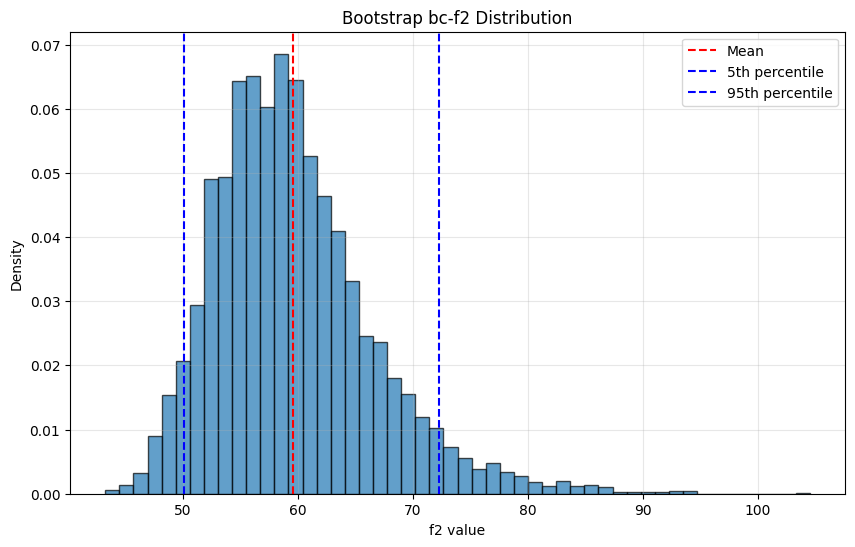

In [19]:
# Plot the bootstrap distribution
plt.figure(figsize=(10, 6))
plt.hist(f2_bs_bc, bins=50, density=True, alpha=0.7, edgecolor='black')
plt.axvline(f2_bs_bc.mean(), color='red', linestyle='--', label='Mean')
plt.axvline(np.percentile(f2_bs_bc, 5), color='blue', linestyle='--', label='5th percentile')
plt.axvline(np.percentile(f2_bs_bc, 95), color='blue', linestyle='--', label='95th percentile')
plt.xlabel('f2 value')
plt.ylabel('Density')
plt.title('Bootstrap bc-f2 Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()